<a href="https://colab.research.google.com/github/deb-kit2/denoise_images/blob/main/doc_denoising_EncDec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, output
drive.mount("/content/drive")
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/denoise")

output.eval_js('new Audio("https://ssl.gstatic.com/dictionary/static/sounds/20180430/complete--_us_1.mp3").play()')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

%matplotlib inline

##helpers

In [3]:
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array

In [23]:
!pip install 
import PIL.Image

def preprocess(image):
  img = PIL.Image.open(image)
  img = PIL.Image.convert('L')
  img = PIL.Image.resize((685, 1000)) #width, height
  img = np.float32(img)
  img /= 255.0
  return img

def put_on_screen(image, size):
  img = image*255.0
  img = np.clip(image, 0.0, 255.0)
  img = img.astype(np.uint8)
  img = PIL.Image.fromarray(img)
  display (img)

In [ ]:
import cv2

def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (685, 1000))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (1000, 685, 1))
    
    return img

##loading data

In [4]:
path = '/content/drive/My Drive/Colab Notebooks/denoise/'

In [5]:
dirty_names = os.listdir(path + 'in')
clean_names = os.listdir(path + 'out')

In [6]:
from tqdm import tqdm
import numpy as np

dirty = []
clean = []

for f in tqdm(dirty_names):
    t = load_img(path + '/in/' + f, grayscale = True, target_size = (1000, 688))
    t = img_to_array(t).astype('float32')/255.0
    dirty.append(t)

for f in tqdm(clean_names):
    t = load_img(path + '/out/' + f, grayscale = True, target_size = (1000, 688))
    t = img_to_array(t).astype('float32')/255.0
    clean.append(t)

dirty = np.array(dirty)
clean = np.array(clean)

output.eval_js('new Audio("https://ssl.gstatic.com/dictionary/static/sounds/20180430/complete--_us_1.mp3").play()')

  0%|          | 0/315 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 315/315 [00:37<00:00,  8.44it/s]


In [7]:
#np.save("dirty", dirty)
#np.save("clean", clean)

In [7]:
print(dirty.shape)
print(clean.shape)

(315, 1000, 688, 1)
(315, 1000, 688, 1)


In [8]:
xtrain, xval, ytrain, yval = train_test_split(dirty, clean, test_size = 0.15)

In [9]:
print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)

(267, 1000, 688, 1)
(267, 1000, 688, 1)
(48, 1000, 688, 1)
(48, 1000, 688, 1)


In [10]:
for i in range(267):
  if xval.shape != yval.shape:
    print(i)
    break;

##modelling

In [10]:
def model():
    input_layer = Input(shape = (1000, 688, 1))

    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)
    #add maxpooling

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x)
    model = Model(inputs = [input_layer], outputs = [output_layer])
    model.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = ['mae'])

    return model


model = model()
#model.summary()

In [11]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 688, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1000, 688, 64)     640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 688, 128)    73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 688, 128)    512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 500, 344, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 500, 344, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 500, 344, 128)    

In [13]:
callback = EarlyStopping(monitor = 'loss', patience = 15)
history = model.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = 200, batch_size = 8, verbose = 1, callbacks = [callback])

Epoch 1/200
34/34 [==============================] - 27s 800ms/step - loss: 0.0896 - mae: 0.1889 - val_loss: 0.3223 - val_mae: 0.5623
Epoch 2/200
34/34 [==============================] - 26s 751ms/step - loss: 0.0499 - mae: 0.1199 - val_loss: 0.0289 - val_mae: 0.0787
Epoch 3/200
34/34 [==============================] - 26s 750ms/step - loss: 0.0339 - mae: 0.0929 - val_loss: 0.0288 - val_mae: 0.0602
Epoch 4/200
34/34 [==============================] - 26s 751ms/step - loss: 0.0310 - mae: 0.0744 - val_loss: 0.0278 - val_mae: 0.0506
Epoch 5/200
34/34 [==============================] - 25s 749ms/step - loss: 0.0296 - mae: 0.0676 - val_loss: 0.0271 - val_mae: 0.0481
Epoch 6/200
34/34 [==============================] - 25s 750ms/step - loss: 0.0287 - mae: 0.0692 - val_loss: 0.0271 - val_mae: 0.0475
Epoch 7/200
34/34 [==============================] - 25s 750ms/step - loss: 0.0263 - mae: 0.0802 - val_loss: 0.0274 - val_mae: 0.0409
Epoch 8/200
34/34 [==============================] - 26s 750ms

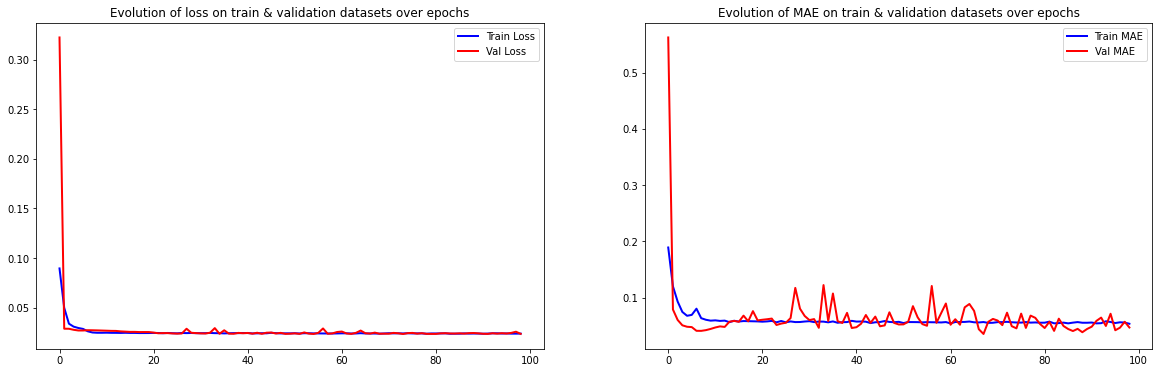

In [16]:
import matplotlib.pyplot as plt

epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [17]:
model.save("check1.h5")

##test with 2 images

In [21]:
test_names = os.listdir("/content/")
test = []

for f in tqdm(test_names):
    if(f.endswith('.jpg')):
        t = load_img("/content/" + f, grayscale = True, target_size = (1000, 688))
        t = img_to_array(t).astype('float32')/255.0
        test.append(t)

test = np.array(test)
test.shape

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 5/5 [00:00<00:00, 35.85it/s]


In [24]:
result = model.predict(test)

In [25]:
result.shape

(2, 1000, 688, 1)

In [ ]:
def display_image_in_actual_size(im_data):

    dpi = 80
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data[:,:,0], cmap='gray')

    plt.show()

display_image_in_actual_size(result[0])

In [ ]:
display_image_in_actual_size(result[1])

In [40]:
imsave("res2.jpg", result[0][:,:,0])